In [1]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.impute import MissingIndicator
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from google.colab import drive

In [3]:
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
data=pd.read_csv("/content/drive/MyDrive/data/elec.csv") #transfer data cv to pandas

In [ ]:
data

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964
...,...,...,...,...,...,...,...,...,...
52411,12/30/2017 23:10,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212
52412,12/30/2017 23:20,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152
52413,12/30/2017 23:30,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259
52414,12/30/2017 23:40,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504


In [5]:
data.index=data['DateTime']


In [6]:
data=data.drop('DateTime',axis=1)

In [7]:
test_na=MissingIndicator()
test_na.fit_transform(data)

array([], shape=(52416, 0), dtype=bool)

In [8]:
data.index=pd.date_range(start='1/1/2017', periods=len(data), freq='10min')

In [9]:
data=data.resample('H').mean()

In [10]:
df=data.drop(['Zone 2  Power Consumption','Zone 3  Power Consumption'],axis=1)

In [11]:
df.head()

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption
2017-01-01 00:00:00,6.196833,75.066667,0.081833,0.063500,0.098833,29197.974683
2017-01-01 01:00:00,5.548833,77.583333,0.082000,0.056833,0.112500,24657.215190
2017-01-01 02:00:00,5.054333,78.933333,0.082333,0.063000,0.129167,22083.037973
2017-01-01 03:00:00,5.004333,77.083333,0.082833,0.059833,0.141000,20811.139240
2017-01-01 04:00:00,5.097667,74.050000,0.082333,0.058000,0.122833,20475.949367


In [12]:
y=np.array(df['Zone 1 Power Consumption'])

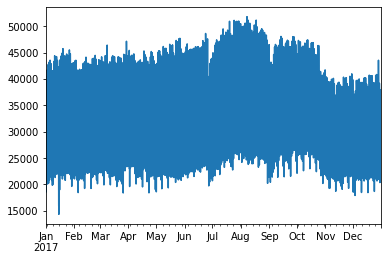

In [13]:
df['Zone 1 Power Consumption'].plot()


In [14]:
X=[]
y_=[]
for i in range( len(y)-5):
  rows=[[a] for a in y[i:i+5]]
  X.append(rows)
  y_.append(y[i+5])
X=np.array(X)
y_=np.array(y_)

In [15]:
y_work=(y_-y_.min())/(y_.max()-y_.min())
X_work=(X-X.min())/(X.max()-X.min())

In [16]:
X.shape,y_.shape

((8731, 5, 1), (8731,))

In [17]:
X_train,X_test,y_train,y_test=train_test_split(X_work,y_work,test_size=0.2)

In [18]:
model1=tf.keras.Sequential()
model1.add(keras.layers.Input((5,1)))
model1.add(keras.layers.Conv1D(28,3,activation="relu"))
model1.add(keras.layers.MaxPooling1D(1))
model1.add(keras.layers.Dropout(0.2))
model1.add(keras.layers.LSTM(60))
model1.add(keras.layers.Dense(8,activation="relu"))
model1.add(keras.layers.Dense(2,activation="linear"))


In [19]:
#complie
model1.compile(optimizer="adam",
              loss=keras.losses.mean_squared_error,
              metrics=[keras.metrics.RootMeanSquaredError()]
)

In [20]:
c=keras.callbacks.ModelCheckpoint("model1/",save_best_only=True)

In [73]:
history=model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=5,callbacks=[c])

Epoch 1/5
219/219 [==============================] - 1s 6ms/step - loss: 0.0027 - root_mean_squared_error: 0.0519 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0496
Epoch 2/5
219/219 [==============================] - 1s 6ms/step - loss: 0.0027 - root_mean_squared_error: 0.0517 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0454
Epoch 3/5
219/219 [==============================] - 1s 6ms/step - loss: 0.0026 - root_mean_squared_error: 0.0513 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0444
Epoch 4/5
219/219 [==============================] - 1s 6ms/step - loss: 0.0027 - root_mean_squared_error: 0.0522 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0453
Epoch 5/5
215/219 [============================>.] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0502

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


219/219 [==============================] - 7s 33ms/step - loss: 0.0025 - root_mean_squared_error: 0.0502 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0428


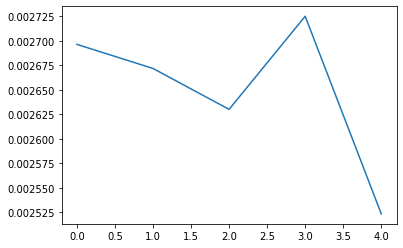

In [74]:
#plot loss
plt.plot(history.history["loss"])

In [75]:
prediction=model1.predict(X_test)
predictions=prediction[:,0]

In [76]:
predictions=predictions*(X.max()-X.min())+X.min()
exact=y_test*(X.max()-X.min())+X.min()

In [77]:
from sklearn.metrics import mean_squared_error
testScore = np.sqrt(mean_squared_error(predictions,exact ))
if(testScore<exact.std()):
  print("le test score",testScore)
  print("l ecart type de le y_test",exact.std())
  print("good")

le test score 1607.2552775886784
l ecart type de le y_test 7167.007052456546
good


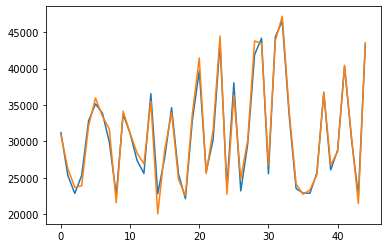

In [78]:
plt.plot(predictions[:45])
plt.plot(exact[:45])

In [79]:
df=pd.DataFrame(predictions,columns=['predicion'])
df['exact']=exact

In [80]:
df.head()

,predicion,exact
0,31206.449219,30885.339073
1,25328.843750,26257.699113
2,22848.847656,23693.617022
3,25309.859375,23899.763187
4,32820.171875,32129.784538


In [71]:
#her i test it for new data its zone 3

In [44]:
def pred(model,data):
    predict=model.predict(data)
    return predict[:,0]

In [59]:
filter=np.array(data['Zone 3  Power Consumption'])

In [60]:
dataframe=[]
for i in range( len(filter[:210])-5):
  rows=[[a] for a in filter[i:i+5]]
  dataframe.append(rows)
dataframe=np.array(dataframe)

In [61]:
data_=(dataframe-dataframe.min())/(dataframe.max()-dataframe.min())

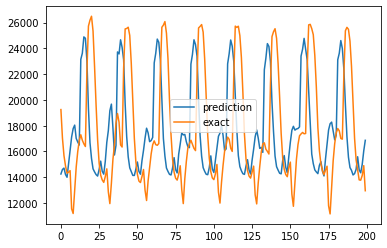

In [72]:
trad=pred(model1,data_)*(dataframe.max()-dataframe.min())+dataframe.min()
plt.plot(trad[:200],label='prediction')
plt.plot(filter[:200],label='exact')
plt.legend()